In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.sparse import csr_matrix,load_npz, coo_matrix
from tqdm import tqdm
from math import log,exp,sqrt
import logging
import copy
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity


contig_file = "../data/corrected_contig_info_combine.csv"
raw_contact_file = "../data/raw_contact_matrix.npz"
path = "../data"

## Auxiliary function

In [2]:
def sum_rows_excluding_diagonal(sparse_mat):
    sparse_mat = csr_matrix(sparse_mat)
    # Get the shape of the matrix
    n_rows, n_cols = sparse_mat.shape

    # Initialize an array to store the row sums
    row_sums_excluding_diagonal = np.zeros(n_rows)

    # Iterate over each row
    for i in range(n_rows):
        # Get the start and end indices of the data in the current row
        start_index = sparse_mat.indptr[i]
        end_index = sparse_mat.indptr[i + 1]

        # Get the column indices and data for the current row
        row_indices = sparse_mat.indices[start_index:end_index]
        row_data = sparse_mat.data[start_index:end_index]

        # Sum the elements excluding the diagonal element
        row_sum = sum(row_data[j] for j in range(len(row_data)) if row_indices[j] != i)

        # Store the sum in the result array
        row_sums_excluding_diagonal[i] = row_sum

    return row_sums_excluding_diagonal



In [3]:
def normcc(df):

    df['log_site'] = np.log(df['site'])
    df['log_length'] = np.log(df['length'])
    df['log_covcc'] = np.log(df['covcc'])
    
    exog = df[['log_site', 'log_length', 'log_covcc']]
    endog = df["signal"]
    exog = sm.add_constant(exog)
    glm_nb = sm.GLM(endog, exog, family=sm.families.NegativeBinomial(alpha=1))
    res = glm_nb.fit(method="lbfgs")

    return res.params



In [4]:
def normalizemap(norm_params, metadata, contact_matrix):
    contact_matrix = contact_matrix.tocoo()
    norm_data = []
    mu_vector = []
    for site, length, covcc in zip(metadata["site"], metadata['length'], metadata['covcc']):
        mu_vector.append(np.exp(log(site) * norm_params['log_site'] +
                    log(length) * norm_params['log_length'] +
                    log(covcc) * norm_params['log_covcc'] +
                    norm_params['const']))
        
    scale = np.max(mu_vector)
    for idx, value in enumerate(contact_matrix.data):
        i, j = contact_matrix.row[idx], contact_matrix.col[idx]
        norm_value = scale * value / np.sqrt(mu_vector[i] * mu_vector[j])
        norm_data.append(norm_value)
    
    return coo_matrix((norm_data, (contact_matrix.row, contact_matrix.col)), shape=contact_matrix.shape)


In [5]:
def calculate_true_contact(matrix, metadata, self_loop):
    # calculate the true connection for local similarity
    matrix = coo_matrix(matrix)
    rows = matrix.row
    cols = matrix.col
    
    index = (rows <= cols)
    rows = rows[index]
    cols = cols[index]
    
    true_positive = set()
    for i in tqdm(range(len(rows))):
        row = rows[i]
        col = cols[i]
        if row == col and not self_loop: # if self-loop is False and row = col, then jump over rest code in the cycle, which means row = col point won't be added into the True positive, thus, self-loop is not included. and self-loop false relised.  
            continue
        if metadata["True_identity"][row] != metadata["True_identity"][col]:
            true_positive.add((row,col))
    return true_positive



In [6]:
def extract_info(matrix):
    matrix = coo_matrix(matrix)
    row = matrix.row
    col = matrix.col
    seq = matrix.data
    
    index = (row <= col)
    row = row[index]
    col = col[index]
    seq = seq[index]
    

    return seq,row,col

In [7]:
# Function to calculate AUDRC
def calculate_audrc(scores):
    scores.sort(key=lambda x: x[2], reverse=True)
    true_count = sum(1 for _, _, _, is_tp in scores if is_tp)
    false_count = len(scores) - true_count
    tpr = []
    fpr = []
    thresholds = np.percentile([x[2] for x in scores], np.arange(0, 100, 5))
    for threshold in tqdm(thresholds):
        tp_cumsum = sum(1 for _, _, score, is_tp in scores if score >= threshold and is_tp)
        fp_cumsum = sum(1 for _, _, score, is_tp in scores if score >= threshold and not is_tp)
        positive_count = sum(1 for _, _, score, _ in scores if score >=threshold)
        print(f"tp_cumsum:{tp_cumsum}, fp_cumsum:{fp_cumsum}")
        tpr.append(tp_cumsum / positive_count)
        fpr.append(fp_cumsum / positive_count)
    audrc = auc(fpr, tpr)
    return audrc, tpr, fpr



In [38]:
# Function to calculate AUDRC
def calculate_audrc(scores):
    scores.sort(key=lambda x: x[2], reverse=True)
    true_positive_count = sum(1 for _, _, _, is_tp in scores if is_tp)
    spurious_contact_count = len(scores) - true_positive_count
    tpr = []
    discard_proportion = []
    thresholds = np.percentile([x[2] for x in scores], np.arange(0, 105, 5))
    for threshold in thresholds:
        tp_cumsum = sum(1 for _, _, score, is_tp in scores if score >= threshold and is_tp)
        spurious_cumsum = sum(1 for _, _, score, is_tp in scores if score < threshold and not is_tp)
        tpr.append(tp_cumsum / true_positive_count)
        discard_proportion.append(spurious_cumsum / spurious_contact_count)
    audrc = auc(discard_proportion, tpr)
    return audrc, tpr, discard_proportion

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])

In [9]:
# Function to extract neighbors and edge weights
def extract_neighbors_and_weights(contact_matrix):
    neighbors = {}
    row, col, data = contact_matrix.row, contact_matrix.col, contact_matrix.data
    for i, j, weight in zip(row, col, data):
        if i == j:
            continue  # Skip self-loops
        if i not in neighbors:
            neighbors[i] = {}
        if j not in neighbors:
            neighbors[j] = {}
        neighbors[i][j] = float(weight)
        neighbors[j][i] = float(weight)  
    return neighbors


In [10]:
def salton(matrix, self_loop):
    """we use matrix multiplication to accelarate the process"""
    dense_matrix = matrix.toarray()
    n_rows = dense_matrix.shape[0]
    #self loop included?
    if self_loop == False:
        for i in range(n_rows):
            dense_matrix[i, i] = 0
            
    salton_matrix = cosine_similarity(dense_matrix)
    return coo_matrix(salton_matrix)


In [11]:
def sorenson(matrix, self_loop):
    dense_matrix = matrix.toarray()
    n_rows = dense_matrix.shape[0]
    
    #self loop included?
    if self_loop == False:
        for i in range(n_rows):
            dense_matrix[i, i] = 0
            
    sorenson_matrix = np.zeros((n_rows,n_rows))
    for i in tqdm(range(n_rows)):
        for j in range(i):
            calculation = 2* np.sum(np.minimum(dense_matrix[i], dense_matrix[j]))/(np.sum(dense_matrix[i]) + np.sum(dense_matrix[j]))

            sorenson_matrix[i, j] = calculation
            sorenson_matrix[j, i] = calculation
    return coo_matrix(sorenson_matrix)


In [12]:
def jacard(matrix, self_loop):
    dense_matrix = matrix.toarray()
    n_rows = dense_matrix.shape[0]
    
    #self loop included?
    if self_loop == False:
        for i in range(n_rows):
            dense_matrix[i, i] = 0
            
    jacard_matrix = np.zeros((n_rows,n_rows))
    for i in tqdm(range(n_rows)):
        for j in range(i):
            calculation = np.sum(np.minimum(dense_matrix[i], dense_matrix[j]))/np.sum(np.maximum(dense_matrix[i], dense_matrix[j]))
            jacard_matrix[i, j] = calculation
            jacard_matrix[j, i] = calculation
    return coo_matrix(jacard_matrix)

In [13]:
def lhn(matrix, self_loop):
    dense_matrix = matrix.toarray()
    n_rows = dense_matrix.shape[0]
    
    #self loop included?
    if self_loop == False:
        for i in range(n_rows):
            dense_matrix[i, i] = 0
            
    lhn_matrix = np.zeros((n_rows,n_rows))
    for i in tqdm(range(n_rows)):
        for j in range(i):
            k_u = np.sum(dense_matrix[i])
            k_v = np.sum(dense_matrix[j])
            calculation = np.sum(dense_matrix[i]*dense_matrix[j])
            lhn_matrix[i, j] = calculation
            lhn_matrix[j, i] = calculation
    return coo_matrix(lhn_matrix)

## Data Loading and Preparation

In [14]:
contact_matrix = load_npz(raw_contact_file).tocsr()
meta_data = pd.read_csv(contig_file)


In [15]:
names = ['name', 'site', 'length', 'coverage', 'covcc', "True_identity"]
meta_data.columns = names

In [16]:
# Calculate the row sums excluding the diagonal
signal = sum_rows_excluding_diagonal(contact_matrix)
meta_data["signal"] = signal

In [17]:
# calculate the coffecient
coffecient = normcc(meta_data)

In [18]:
contact_matrix = contact_matrix.tocoo()

## Perform NormCC in the contact_matrix

In [19]:
norm_contact_matrix = normalizemap(coffecient, meta_data, contact_matrix)

In [20]:
print(norm_contact_matrix)

  (0, 0)	871047.8149862476
  (0, 185)	25223.74260893343
  (0, 1430)	19908.193328339174
  (0, 1691)	22223.50955512559
  (0, 2251)	9459.678381011197
  (0, 2638)	2580.973421981295
  (0, 3346)	2206.5943894618167
  (0, 4732)	49581.18391135937
  (1, 1)	769095.3478915871
  (1, 546)	86856.44370238144
  (1, 3689)	10026.792784459714
  (1, 5242)	3069.209125333681
  (2, 2)	735997.8680959569
  (2, 147)	4661.208543857523
  (2, 466)	301.3340560661546
  (2, 508)	3040.617557024541
  (2, 573)	3299.8681705577646
  (2, 701)	318.2078576233044
  (2, 725)	888.2958727568667
  (2, 942)	482.72298967255637
  (2, 958)	372.0449268280038
  (2, 1044)	402.6997121971472
  (2, 1057)	1717.5436588950665
  (2, 1353)	27051.20515295446
  (2, 1494)	16629.352496971318
  :	:
  (5282, 4210)	249.10673638428233
  (5282, 4255)	1834.2582920471561
  (5282, 4280)	522.556921127156
  (5282, 4319)	540.8686327985389
  (5282, 4321)	170.93330060201683
  (5282, 4323)	515.1174566877427
  (5282, 4330)	408.74928201721576
  (5282, 4425)	378.065

## Calculate the local similarity index

In [21]:
self_loop = True

In [22]:
## for salton local index
salton_matrix_raw = salton(contact_matrix, self_loop)
salton_matrix_norm = salton(norm_contact_matrix, self_loop)

In [23]:
## for sorenson local index
sorenson_matrix_raw = sorenson(contact_matrix, self_loop)
sorenson_matrix_norm = sorenson(norm_contact_matrix, self_loop)


100%|██████████| 5283/5283 [03:57<00:00, 22.27it/s] 


In [24]:
## for jacard local index
jacard_matrix_raw = jacard(contact_matrix, self_loop)
jacard_matrix_norm = jacard(norm_contact_matrix, self_loop)

100%|██████████| 5283/5283 [03:40<00:00, 23.97it/s] 


In [25]:
## for lhn local index
lhn_matrix_raw = lhn(contact_matrix, self_loop)

lhn_matrix_norm = lhn(norm_contact_matrix, self_loop)

100%|██████████| 5283/5283 [03:47<00:00, 23.23it/s] 


## Extract data, row, col information n%

In [26]:
##drop out the lowest 10 percent
salton_seq_raw, salton_row_raw, salton_col_raw = extract_info(salton_matrix_raw)
salton_seq_norm, salton_row_norm, salton_col_norm = extract_info(salton_matrix_norm)

In [27]:
sorenson_seq_raw, sorenson_row_raw, sorenson_col_raw = extract_info(sorenson_matrix_raw)
sorenson_seq_norm, sorenson_row_norm, sorenson_col_norm = extract_info(sorenson_matrix_norm)

In [28]:
jacard_seq_raw, jacard_row_raw, jacard_col_raw = extract_info(jacard_matrix_raw)
jacard_seq_norm, jacard_row_norm, jacard_col_norm = extract_info(jacard_matrix_norm)


In [29]:
lhn_seq_raw, lhn_row_raw, lhn_col_raw = extract_info(lhn_matrix_raw)
lhn_seq_norm, lhn_row_norm, lhn_col_norm = extract_info(lhn_matrix_norm)


## Find out the true positive contacts

In [30]:
## calculate the valid contacts in the map
true_contact = calculate_true_contact(contact_matrix, meta_data, False)

100%|██████████| 562066/562066 [00:03<00:00, 151630.65it/s]


## Draw the local ROC

In [31]:
salton_score_raw = [(i, j, score, (i, j) in true_contact) for (score, i, j) in zip(salton_seq_raw, salton_row_raw, salton_col_raw)]
salton_score_norm = [(i, j, score, (i, j) in true_contact) for (score, i, j) in zip(salton_seq_norm, salton_row_norm, salton_col_norm)]

In [32]:
sorenson_score_raw = [(i, j, score, (i, j) in true_contact) for (score, i, j) in zip(sorenson_seq_raw, sorenson_row_raw, sorenson_col_raw)]
sorenson_score_norm = [(i, j, score, (i, j) in true_contact) for (score, i, j) in zip(sorenson_seq_norm, sorenson_row_norm, sorenson_col_norm )]

In [33]:
jacard_score_raw = [(i, j, score, (i, j) in true_contact) for (score, i, j) in zip(jacard_seq_raw, jacard_row_raw, jacard_col_raw)]
jacard_score_norm = [(i, j, score, (i, j) in true_contact) for (score, i, j) in zip(jacard_seq_norm, jacard_row_norm, jacard_col_norm)]

In [34]:
lhn_score_raw = [(i, j, score, (i, j) in true_contact) for (score, i, j) in zip(lhn_seq_raw, lhn_row_raw, lhn_col_raw)]
lhn_score_norm = [(i, j, score, (i, j) in true_contact) for (score, i, j) in zip(lhn_seq_norm, lhn_row_norm, lhn_col_norm)]

In [39]:
auc_salton_raw, tpr_salton_raw, fpr_salton_raw = calculate_audrc(salton_score_raw)

auc_salton_norm, tpr_salton_norm, fpr_salton_norm = calculate_audrc(salton_score_norm)


In [40]:
auc_sorenson_raw, tpr_sorenson_raw, fpr_sorenson_raw = calculate_audrc(sorenson_score_raw)
auc_sorenson_norm, tpr_sorenson_norm, fpr_sorenson_norm = calculate_audrc(sorenson_score_norm)

In [41]:
auc_jacard_raw, tpr_jacard_raw, fpr_jacard_raw = calculate_audrc(jacard_score_raw)
auc_jacard_norm, tpr_jacard_norm, fpr_jacard_norm = calculate_audrc(jacard_score_norm)

In [42]:
auc_lhn_raw, tpr_lhn_raw, fpr_lhn_raw = calculate_audrc(lhn_score_raw)
auc_lhn_norm, tpr_lhn_norm, fpr_lhn_norm = calculate_audrc(lhn_score_norm)

In [ ]:
auc_salton_raw

In [43]:
# Function to plot the discard-retain curve
def plot_discard_retain_curve(discard_proportion, tpr, audrc, method_label, color):
    plt.plot(discard_proportion, tpr, label=f'{method_label}: {audrc:.3f}', color=color)

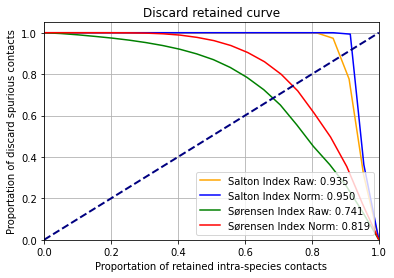

In [44]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2  # line width


plot_discard_retain_curve(fpr_salton_raw, tpr_salton_raw, auc_salton_raw, 'Salton Index Raw', 'orange')
plot_discard_retain_curve(fpr_salton_norm, tpr_salton_norm, auc_salton_norm, 'Salton Index Norm', 'blue')
plot_discard_retain_curve(fpr_sorenson_raw, tpr_sorenson_raw, auc_sorenson_raw, 'Sørensen Index Raw', 'green')
plot_discard_retain_curve(fpr_sorenson_norm, tpr_sorenson_norm, auc_sorenson_norm, 'Sørensen Index Norm', 'red')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Proportation of retained intra-species contacts')
plt.ylabel('Proportation of discard spurious contacts')
plt.title('Discard retained curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

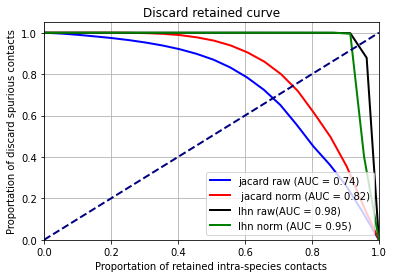

In [45]:
plt.figure()
lw = 2  # line width
plt.plot(fpr_jacard_raw, tpr_jacard_raw, color='blue', lw=lw, label=f'jacard raw (AUC = {auc_jacard_raw:.2f})')
plt.plot(fpr_jacard_norm, tpr_jacard_norm, color="red", lw=lw, label=f' jacard norm (AUC = {auc_jacard_norm:.2f})')
plt.plot(fpr_lhn_raw, tpr_lhn_raw, color='black', lw=lw, label=f'lhn raw(AUC = {auc_lhn_raw:.2f})')
plt.plot(fpr_lhn_norm, tpr_lhn_norm, color="green",lw=lw, label=f'lhn norm (AUC = {auc_lhn_norm:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Proportation of retained intra-species contacts')
plt.ylabel('Proportation of discard spurious contacts')
plt.title('Discard retained curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()